# Regresión Ponderada Geográficamente (GWR)
[mgwr: A Python Implementation of Multiscale Geographically Weighted Regression for Investigating Process Spatial Heterogeneity and Scale](https://chatgpt.com/g/g-p-6793d17eed5481919a3d029f78b11e15-t3chfest/c/67be02ea-86f4-8005-8fb5-e486229cb624#:~:text=revisar%20el%20art%C3%ADculo%20%22-,mgwr%3A%20A%20Python%20Implementation%20of%20Multiscale%20Geographically%20Weighted%20Regression%20for%20Investigating%20Process%20Spatial%20Heterogeneity%20and%20Scale,-%22.)

## Librerías

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


## Datasets

### Seleccionar año

In [30]:
CENSUS_YEAR = 2019 # 2015, 2019, 2023
ELECTORAL_YEAR = CENSUS_YEAR + 1

### Cargar datos

In [31]:
data = pd.read_csv(f'data/final_data_{ELECTORAL_YEAR}.csv')

## Regresión

<div style="border-left: 4px solid #17a2b8; background-color: #e8f8ff; padding: 10px;">
    <strong>🎯Objetivo:</strong> Predecir el porcentaje de votos a Biden en cada condado (y, por tanto, también el de Trump).
</div>


#### Dataset

In [32]:
# columns_to_drop = ["votes_gop", "votes_dem", "total_votes", "votes_others", "per_votes_others", "winner",
#                    'county_fips', "county", "state_code", "county_code"]  # Nombres de las columnas a eliminar

fips = data['county_fips'].astype(str).str.zfill(5)
columns_to_drop = ["per_dem", "per_gop", "delta_per_oth",
                    "votes_gop", "votes_dem", "total_votes", "votes_others", "per_votes_others", "winner",
                    'county_fips', "county", "state_code", "county_code"]  # Nombres de las columnas a eliminar

data_reg = data.drop(columns=columns_to_drop)
data_reg

,state,pop_total,median_age,median_income,households_median_value,households_avg_size,households_total,households_median_gross_rent,mean_travel_time,pop_total_male_rate,...,poverty_rate,households_renter_rate,households_owner_rate,unemployment_rate,public_transport_rate,no_health_insurance_rate,delta_per_dem,delta_per_gop,latitude,longitude
0,Alabama,55380,38.2,58731,154500,2.56,21397,986,23796,48.63,...,15.06,26.71,73.29,3.68,0.29,6.96,3.061510,-1.998987,32.536153,-86.641196
1,Alabama,212830,43.0,58320,197900,2.59,80930,1020,87084,48.63,...,10.20,24.75,75.25,4.26,0.02,8.78,2.843720,-1.180099,30.725862,-87.723954
2,Alabama,25361,40.4,32525,90700,2.41,9345,576,8108,52.92,...,27.11,39.10,60.90,9.17,0.11,10.03,-0.872078,1.179812,31.867889,-85.389245
3,Alabama,22493,40.9,47542,92800,2.99,6891,734,7910,54.02,...,16.63,25.58,74.42,7.28,0.00,9.79,-0.723759,1.460100,32.996456,-87.124963
4,Alabama,57681,40.7,49358,127800,2.74,20847,667,21361,49.40,...,13.42,21.22,78.78,3.36,0.05,10.68,1.099476,-0.280322,33.985248,-86.569756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,Wyoming,43521,35.3,74843,205600,2.77,15523,861,20717,51.63,...,11.31,23.78,76.22,6.09,1.41,11.18,3.621362,0.712563,41.660236,-108.879456
3103,Wyoming,23280,39.3,84678,866600,2.47,9019,1376,13079,52.94,...,6.13,39.59,60.41,1.08,2.12,12.71,7.037406,-2.617592,43.935079,-110.589127
3104,Wyoming,20479,35.8,63403,175000,2.66,7597,698,8960,50.81,...,11.22,22.94,77.06,6.28,1.47,11.09,1.995817,3.308992,41.287415,-110.547551
3105,Wyoming,8027,42.9,54158,165800,2.34,3365,640,3512,50.64,...,10.28,23.51,76.49,3.92,0.00,14.73,1.905998,2.524345,43.904771,-107.681649


#### Data Splitting

In [33]:
# X = data_reg.drop(columns=["per_dem", "per_gop"])  # Características (sin la columna objetivo)
X = data_reg.drop(columns=["delta_per_dem", "delta_per_gop"])  # Características (sin la columna objetivo)

In [34]:
# # Crear las columnas dummy a partir de la columna 'state'
# dummies = pd.get_dummies(X['state'], prefix='state', drop_first=False)

# # Concatenar las columnas dummy al DataFrame original, conservando la columna 'state'
# X = pd.concat([X, dummies], axis=1)

# X.head()

In [35]:
y_dem = data_reg["delta_per_dem"]
y_gop = data_reg["delta_per_gop"]

In [36]:
columns_to_drop = ["state"]  # Nombres de las columnas a eliminar
X = X.drop(columns=columns_to_drop)
X

,pop_total,median_age,median_income,households_median_value,households_avg_size,households_total,households_median_gross_rent,mean_travel_time,pop_total_male_rate,pop_total_female_rate,...,high_school_rate,bachelors_rate,poverty_rate,households_renter_rate,households_owner_rate,unemployment_rate,public_transport_rate,no_health_insurance_rate,latitude,longitude
0,55380,38.2,58731,154500,2.56,21397,986,23796,48.63,51.37,...,19.21,10.87,15.06,26.71,73.29,3.68,0.29,6.96,32.536153,-86.641196
1,212830,43.0,58320,197900,2.59,80930,1020,87084,48.63,51.37,...,15.90,14.94,10.20,24.75,75.25,4.26,0.02,8.78,30.725862,-87.723954
2,25361,40.4,32525,90700,2.41,9345,576,8108,52.92,47.08,...,20.10,5.39,27.11,39.10,60.90,9.17,0.11,10.03,31.867889,-85.389245
3,22493,40.9,47542,92800,2.99,6891,734,7910,54.02,45.98,...,25.35,4.64,16.63,25.58,74.42,7.28,0.00,9.79,32.996456,-87.124963
4,57681,40.7,49358,127800,2.74,20847,667,21361,49.40,50.60,...,18.57,5.95,13.42,21.22,78.78,3.36,0.05,10.68,33.985248,-86.569756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,43521,35.3,74843,205600,2.77,15523,861,20717,51.63,48.37,...,16.58,9.50,11.31,23.78,76.22,6.09,1.41,11.18,41.660236,-108.879456
3103,23280,39.3,84678,866600,2.47,9019,1376,13079,52.94,47.06,...,10.19,28.98,6.13,39.59,60.41,1.08,2.12,12.71,43.935079,-110.589127
3104,20479,35.8,63403,175000,2.66,7597,698,8960,50.81,49.19,...,21.49,7.00,11.22,22.94,77.06,6.28,1.47,11.09,41.287415,-110.547551
3105,8027,42.9,54158,165800,2.34,3365,640,3512,50.64,49.36,...,15.72,10.64,10.28,23.51,76.49,3.92,0.00,14.73,43.904771,-107.681649


#### Multicolinealidad

In [37]:
# import numpy as np
# import pandas as pd
# from numpy.linalg import cond

# # 🔹 Asegurar que X solo tenga variables numéricas
# X_numeric = X.select_dtypes(include=[np.number]).astype(np.float64)

# # 🔹 Calcular índice de condición
# condition_index = cond(X_numeric)

# # 🔹 Verificar si hay multicolinealidad fuerte
# print(f"Índice de Condición de X: {condition_index}")

# if condition_index > 30:
#     print("⚠️ Alerta: Multicolinealidad fuerte detectada en X")


In [38]:
# import pandas as pd

# # Calcular la matriz de correlación
# corr_matrix = X.corr().abs()

# # Identificar pares de variables con correlación > 0.95
# high_corr_vars = set()
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if corr_matrix.iloc[i, j] > 0.95:
#             colname = X.columns[i]
#             high_corr_vars.add(colname)

# print(f"Variables altamente correlacionadas: {high_corr_vars}")

# # Eliminar variables correlacionadas
# X = X.drop(columns=high_corr_vars, errors='ignore')

#### Benchmark Model

In [39]:
# Resumen estadístico
print(y_dem.describe())

count    3107.000000
mean        1.568644
std         2.950623
min       -27.029415
25%        -0.120022
50%         1.480919
75%         3.274571
max        14.941948
Name: delta_per_dem, dtype: float64


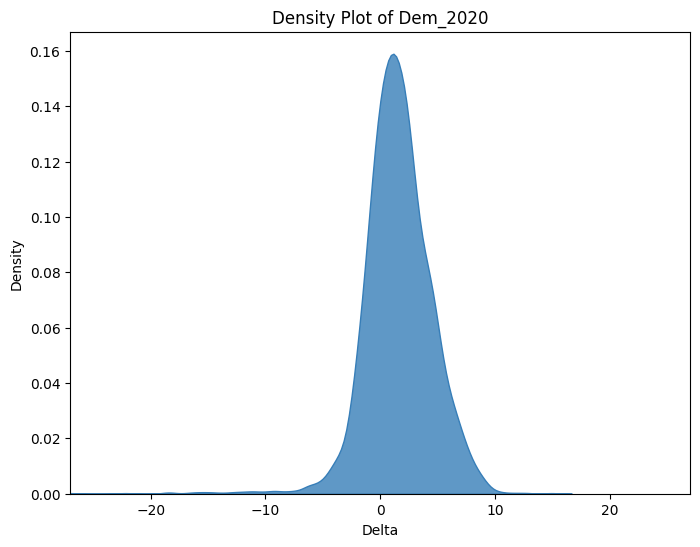

In [40]:
# Crear la gráfica de densidad
plt.figure(figsize=(8, 6))
sns.kdeplot(y_dem, color="#377eb8", fill=True, alpha=0.8)

# Configurar el título y etiquetas
plt.title(f"Density Plot of Dem_{ELECTORAL_YEAR}")
# plt.xlabel(f"per_dem_{ELECTORAL_YEAR}")
plt.xlabel("Delta")
plt.ylabel("Density")
# plt.xlim(-0.1, 1)
plt.xlim(min(y_dem), abs(min(y_dem)))

# Mostrar la gráfica
plt.show()

In [41]:
average_dem = y_dem.mean()

# Usar f-strings para concatenar el mensaje y el valor promedio
print(f"Av. Dem: {average_dem}")

Av. Dem: 1.5686435948748474


#### Importancia de las variables

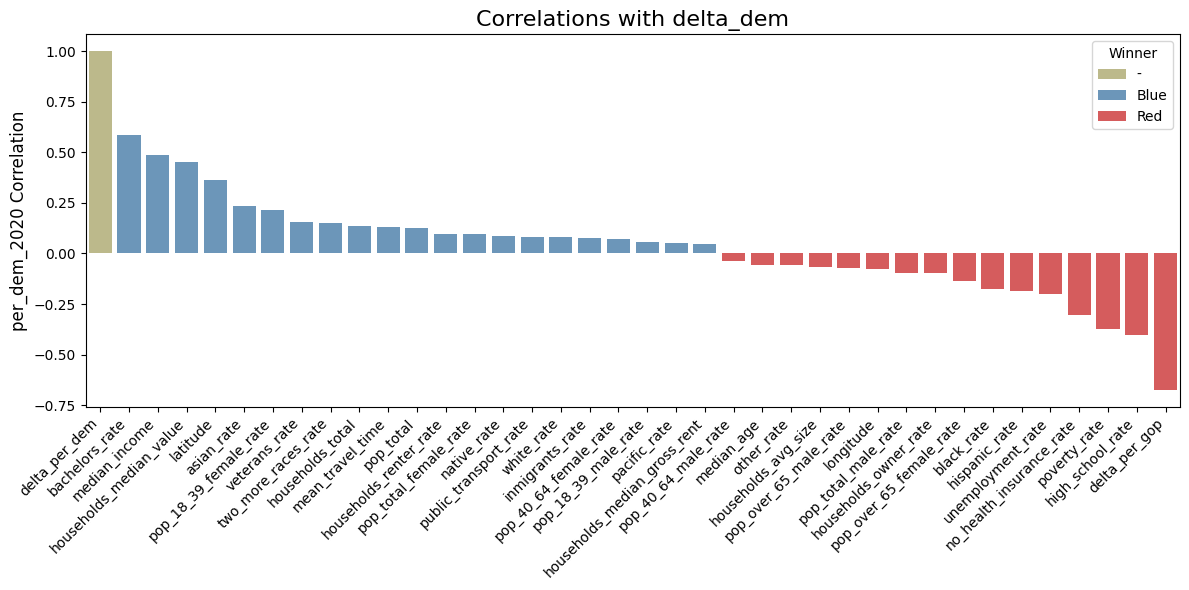

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Filtrar solo columnas numéricas
numeric_data = data_reg.select_dtypes(include=[np.number])

# Paso 2: Calcular las correlaciones
# corr_votes = numeric_data.corr()["per_dem"].sort_values(ascending=False)
corr_votes = numeric_data.corr()["delta_per_dem"].sort_values(ascending=False)


# Paso 3: Crear el DataFrame de correlaciones
corr_df = pd.DataFrame(corr_votes).reset_index()
corr_df.columns = ['Variable', 'Correlation']

# Clasificar como "Red", "Blue", o "-"
corr_df['Winner'] = np.where(corr_df['Correlation'] < 0, 'Red', 
                             np.where(corr_df['Correlation'] == 1, '-', 'Blue'))

# Paso 4: Visualizar con un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=corr_df, x='Variable', y='Correlation', hue='Winner', dodge=False,
            palette={"Red": "#e41a1c", "Blue": "#377eb8", "-": "#b6b164"}, alpha=0.8)

# plt.title("Correlations with Dem % of Vote", fontsize=16)
plt.title("Correlations with delta_dem", fontsize=16)
plt.xlabel("")
plt.ylabel(f"per_dem_{ELECTORAL_YEAR} Correlation", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Winner')
plt.tight_layout()
plt.show()

🔹 Variables seleccionadas por AIC: ['bachelors_rate', 'high_school_rate', 'hispanic_rate', 'latitude', 'veterans_rate', 'pop_over_65_female_rate', 'public_transport_rate', 'households_median_value', 'pop_total_male_rate', 'native_rate', 'no_health_insurance_rate', 'other_rate', 'pop_18_39_female_rate', 'households_median_gross_rent', 'white_rate', 'longitude', 'median_age', 'pop_40_64_male_rate', 'poverty_rate', 'households_owner_rate', 'unemployment_rate', 'inmigrants_rate', 'asian_rate', 'pacific_rate']
🏆 Top 50 mejores variables: ['bachelors_rate', 'high_school_rate', 'hispanic_rate', 'latitude', 'veterans_rate', 'pop_over_65_female_rate', 'public_transport_rate', 'households_median_value', 'pop_total_male_rate', 'native_rate', 'no_health_insurance_rate', 'other_rate', 'pop_18_39_female_rate', 'households_median_gross_rent', 'white_rate', 'longitude', 'median_age', 'pop_40_64_male_rate', 'poverty_rate', 'households_owner_rate', 'unemployment_rate', 'inmigrants_rate', 'asian_rate', '

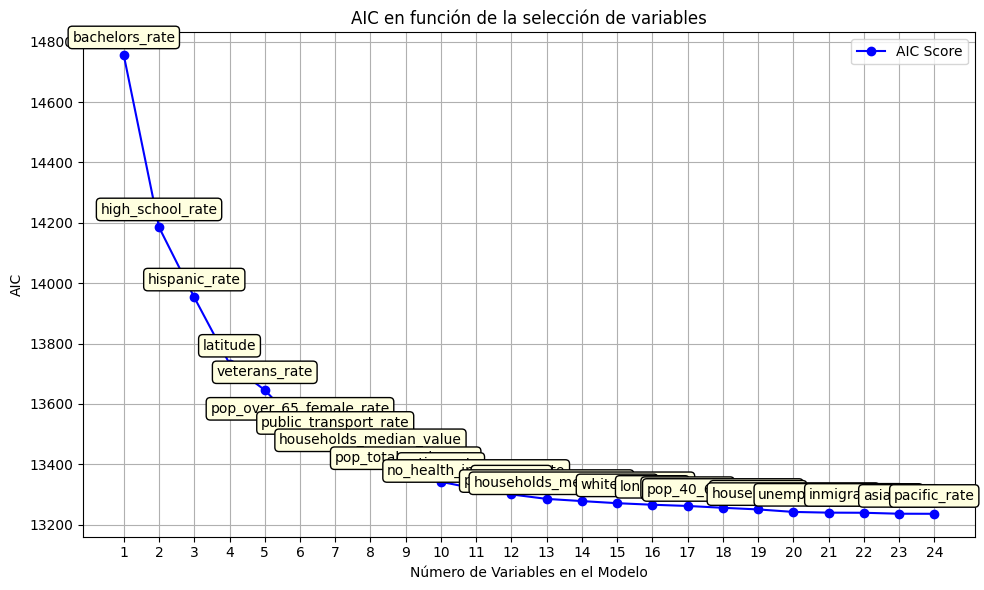

In [43]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

n = 50

# Asegurar que X tenga solo variables numéricas y eliminar NaN
X_fw = X.select_dtypes(include=[np.number]).dropna()
X_fw = sm.add_constant(X_fw)  # Añadir constante

# Función para la selección hacia adelante basada en AIC
def forward_selection(y, X):
    remaining_features = X.columns.tolist()
    selected_features = []
    best_aic = float('inf')
    aic_history = []

    while remaining_features:
        aic_candidates = []

        for feature in remaining_features:
            model = sm.OLS(y, X[selected_features + [feature]]).fit()
            aic_candidates.append((model.aic, feature))

        # Ordenar por menor AIC y seleccionar la mejor variable
        aic_candidates.sort()
        current_aic, best_feature = aic_candidates[0]

        # Detener si no hay mejora significativa en AIC
        if current_aic < best_aic - 0.01:  # Se usa 0.01 para evitar selección de variables irrelevantes
            best_aic = current_aic
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            aic_history.append(best_aic)
        else:
            break  # Si AIC no mejora, detener

    return selected_features, aic_history

# Ejecutar la selección hacia adelante
selected_features, aic_history = forward_selection(y_dem, X_fw)

# Seleccionar las 10 mejores variables según el orden en AIC
top_n_features = selected_features[:n]

# Mostrar los resultados
print("🔹 Variables seleccionadas por AIC:", selected_features)
print(f"🏆 Top {n} mejores variables:", top_n_features)

# 📊 **Visualizar la evolución del AIC**
plt.figure(figsize=(10, 6))
plt.plot(aic_history, marker='o', linestyle='-', color='b', label="AIC Score")
plt.title('AIC en función de la selección de variables')
plt.xlabel('Número de Variables en el Modelo')
plt.ylabel('AIC')
plt.xticks(range(len(aic_history)), range(1, len(aic_history) + 1))  # Etiquetas de número de variables
plt.grid()

# Añadir etiquetas con el nombre de las variables seleccionadas
for i, feature in enumerate(selected_features):
    plt.annotate(feature, 
                 (i, aic_history[i]),  
                 textcoords="offset points", 
                 xytext=(0, 10),  
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightyellow'))

plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# 🔹 Verificar y agregar 'longitude' y 'latitude' solo si no están en la lista
if "longitude" not in top_n_features:
    top_n_features.append("longitude")

if "latitude" not in top_n_features:
    top_n_features.append("latitude")

# 🔹 Filtrar X y X_test con las variables seleccionadas
X = X[top_n_features]


In [45]:
X

,bachelors_rate,high_school_rate,hispanic_rate,latitude,veterans_rate,pop_over_65_female_rate,public_transport_rate,households_median_value,pop_total_male_rate,native_rate,...,white_rate,longitude,median_age,pop_40_64_male_rate,poverty_rate,households_owner_rate,unemployment_rate,inmigrants_rate,asian_rate,pacific_rate
0,10.87,19.21,2.83,32.536153,9.52,8.47,0.29,154500,48.63,0.25,...,76.79,-86.641196,38.2,15.65,15.06,73.29,3.68,2.35,1.03,0.05
1,14.94,15.90,4.56,30.725862,9.24,10.71,0.02,197900,48.63,0.77,...,86.21,-87.723954,43.0,16.02,10.20,75.25,4.26,3.72,0.93,0.00
2,5.39,20.10,4.36,31.867889,5.24,10.58,0.11,90700,52.92,0.32,...,46.80,-85.389245,40.4,17.41,27.11,60.90,9.17,2.72,0.53,0.00
3,4.64,25.35,2.57,32.996456,6.37,8.84,0.00,92800,54.02,0.13,...,76.79,-87.124963,40.9,18.81,16.63,74.42,7.28,1.51,0.12,0.00
4,5.95,18.57,9.26,33.985248,5.92,9.91,0.05,127800,49.40,0.08,...,95.46,-86.569756,40.7,16.79,13.42,78.78,3.36,4.54,0.37,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,9.50,16.58,15.88,41.660236,6.32,5.97,1.41,205600,51.63,1.17,...,93.38,-108.879456,35.3,16.29,11.31,76.22,6.09,4.67,0.78,0.04
3103,28.98,10.19,15.03,43.935079,4.29,7.11,2.12,866600,52.94,0.33,...,89.28,-110.589127,39.3,17.86,6.13,60.41,1.08,11.78,1.25,0.12
3104,7.00,21.49,9.13,41.287415,5.22,6.54,1.47,175000,50.81,0.71,...,93.42,-110.547551,35.8,15.55,11.22,77.06,6.28,2.90,0.16,0.00
3105,10.64,15.72,14.23,43.904771,8.96,11.12,0.00,165800,50.64,0.95,...,89.75,-107.681649,42.9,16.77,10.28,76.49,3.92,1.56,0.00,0.00


## Models

The bandwidth parameter is the distance or number of nearest neighbors away in space that the remaining observations have no influence

### Dem

In [46]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import joblib
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 🔹 1. Asegurar que los índices estén alineados
X = X.reset_index(drop=True)
y_dem = y_dem.reset_index(drop=True)

# 🔹 2. Asegurar que X, y y coords estén bien formateados
coords = X[['longitude', 'latitude']].values  # Coordenadas de los condados
X = X.drop(columns=['longitude', 'latitude']).astype(np.float64).values  # Variables sin coordenadas
X = scaler.fit_transform(X)  # Escalar las variables
y = y_dem.values.reshape((-1, 1))  # Convertir y a (n, 1)

# 🔹 3. Verificar dimensiones antes de usar GWR
print(f"📊 Dimensiones antes de GWR:")
print(f"X Shape: {X.shape}, y Shape: {y.shape}, Coords Shape: {coords.shape}")

# 🔹 4. Seleccionar el ancho de banda óptimo
selector = Sel_BW(coords, y, X)
bw = selector.search(search_method = 'interval',
               interval = 5,
               bw_min = 101,
               bw_max = 500)
print(f"✅ Ancho de banda óptimo: {bw}")

# 🔹 5. Ajustar el modelo GWR
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# # 🔹 6. Guardar el modelo GWR
joblib.dump(gwr_model, f'models/gwr_delta_dem_{ELECTORAL_YEAR}.pkl')

📊 Dimensiones antes de GWR:
X Shape: (3107, 22), y Shape: (3107, 1), Coords Shape: (3107, 2)


/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/urllib3/__init_

✅ Ancho de banda óptimo: 361


/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.80272e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)


['models/gwr_delta_dem_2020.pkl']

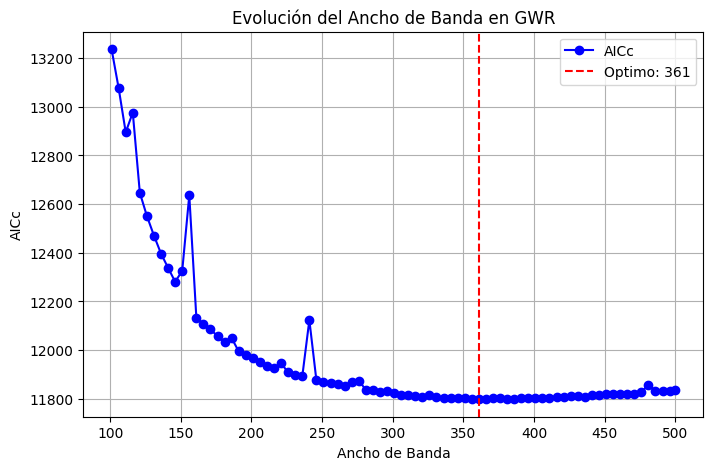

In [47]:
import matplotlib.pyplot as plt

# Extraer historial de selección de bw
bw_history = selector.sel_hist

# Convertir a DataFrame para analizar los cambios
bw_df = pd.DataFrame(bw_history, columns=["bw", "AICc"])
bw_df = bw_df.sort_values(by="bw")  # Ordenar por ancho de banda

# 🔹 Gráfico de AICc vs. ancho de banda
plt.figure(figsize=(8, 5))
plt.plot(bw_df["bw"], bw_df["AICc"], marker="o", linestyle="-", color="b", label="AICc")
plt.axvline(x=bw, color="r", linestyle="--", label=f"Optimo: {bw}")
plt.xlabel("Ancho de Banda")
plt.ylabel("AICc")
plt.title("Evolución del Ancho de Banda en GWR")
plt.legend()
plt.grid()
plt.show()

In [48]:
gwr_results.R2

np.float64(0.7863955117565377)

In [49]:
gwr_results.localR2

array([[0.76766181],
       [0.72075031],
       [0.76238815],
       ...,
       [0.61005729],
       [0.69050155],
       [0.7083943 ]])

In [50]:
fips = fips.astype(str).str.zfill(5)

In [51]:
import plotly.express as px

# 🔹 Crear un DataFrame con FIPS y R² local
gwr_r2_df = pd.DataFrame({
    "fips": fips,  # Código de condado (debes asegurarte de tenerlo)
    "local_R2": gwr_results.localR2.flatten()  # Asegurar que es 1D
})



# 🔹 Graficar el mapa coroplético
fig = px.choropleth(
    gwr_r2_df,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations="fips",
    color="local_R2",
    color_continuous_scale="viridis",
    scope="usa",
    labels={"local_R2": "R² Local"},
    title=f"{ELECTORAL_YEAR} Mapa de R² Local para DEM en GWR"
)

fig.show()


### GOP

In [52]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import joblib
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 🔹 1. Asegurar que los índices estén alineados
y_gop = y_gop.reset_index(drop=True)

# 🔹 2. Asegurar que X, y y coords estén bien formateados
y = y_gop.values.reshape((-1, 1))  # Convertir y a (n, 1)

# 🔹 3. Verificar dimensiones antes de usar GWR
print(f"📊 Dimensiones antes de GWR:")
print(f"X Shape: {X.shape}, y Shape: {y.shape}, Coords Shape: {coords.shape}")

# 🔹 4. Seleccionar el ancho de banda óptimo
selector = Sel_BW(coords, y, X)
bw = selector.search(search_method = 'interval',
               interval = 5,
               bw_min = 101,
               bw_max = 500)
print(f"✅ Ancho de banda óptimo: {bw}")

# 🔹 5. Ajustar el modelo GWR
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# # 🔹 6. Guardar el modelo GWR
joblib.dump(gwr_model, f'models/gwr_delta_gop_{ELECTORAL_YEAR}.pkl')

📊 Dimensiones antes de GWR:
X Shape: (3107, 22), y Shape: (3107, 1), Coords Shape: (3107, 2)


/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.08327e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.02065e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.79567e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.70686e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/i

✅ Ancho de banda óptimo: 246


/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.59028e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.6304e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.07193e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.25324e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/Users/jorgegarcelan/Desktop/T3CHFEST/US-Elections/.venv/lib/python3.9/site-packages/spglm/iw

['models/gwr_delta_gop_2020.pkl']

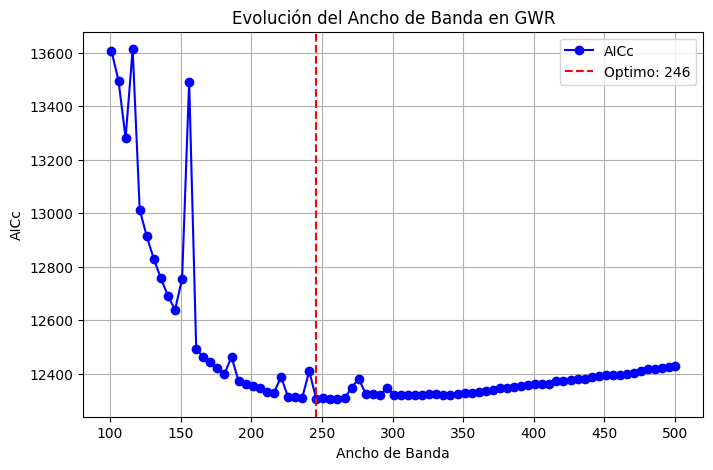

In [53]:
import matplotlib.pyplot as plt

# Extraer historial de selección de bw
bw_history = selector.sel_hist

# Convertir a DataFrame para analizar los cambios
bw_df = pd.DataFrame(bw_history, columns=["bw", "AICc"])
bw_df = bw_df.sort_values(by="bw")  # Ordenar por ancho de banda

# 🔹 Gráfico de AICc vs. ancho de banda
plt.figure(figsize=(8, 5))
plt.plot(bw_df["bw"], bw_df["AICc"], marker="o", linestyle="-", color="b", label="AICc")
plt.axvline(x=bw, color="r", linestyle="--", label=f"Optimo: {bw}")
plt.xlabel("Ancho de Banda")
plt.ylabel("AICc")
plt.title("Evolución del Ancho de Banda en GWR")
plt.legend()
plt.grid()
plt.show()


In [54]:
gwr_results.R2

np.float64(0.775095167871842)

In [55]:
gwr_results.localR2

array([[0.70252561],
       [0.64861154],
       [0.68319124],
       ...,
       [0.84258037],
       [0.81029903],
       [0.39905571]])

In [56]:
import plotly.express as px

# 🔹 Crear un DataFrame con FIPS y R² local
gwr_r2_df = pd.DataFrame({
    "fips": fips,  # Código de condado (debes asegurarte de tenerlo)
    "local_R2": gwr_results.localR2.flatten()  # Asegurar que es 1D
})



# 🔹 Graficar el mapa coroplético
fig = px.choropleth(
    gwr_r2_df,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations="fips",
    color="local_R2",
    color_continuous_scale="viridis",
    scope="usa",
    labels={"local_R2": "R² Local"},
    title=f"{ELECTORAL_YEAR} Mapa de R² Local para GOP en GWR"
)

fig.show()
